In [1]:
#!git clone https://github.com/KayoRBC/TCC.git

In [2]:
from reportlab.rl_settings import verbose
!pip install pandas yfinance numpy matplotlib scikit-learn tensorflow requests joblib pytz python-dateutil pmdarima

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from pandas import DataFrame
import requests
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta

2024-10-07 19:53:57.826431: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 19:53:57.878911: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 19:53:57.935039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 19:53:58.001605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 19:53:58.016122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 19:53:58.104454: I tensorflow/core/platform/cpu_feature_gu

## Seleção das ações
Nesta primeira etapa, iremos pegar as 100 ações da b3 mais negociadas no dia 2023-12-28, ou seja, que possuem o maior "Volume" nesse dia. Além disso, elas precisam ter no mínimo 10 anos de histórico na bolsa.

In [4]:
# contantes
max_history_date = "2023-12-28"

In [5]:
def somar_um_dia(date: str) -> str:
  data = datetime.strptime(date, "%Y-%m-%d")
  date = data + timedelta(days=1)
  return date.strftime("%Y-%m-%d")

In [6]:
def get_b3_ticker_symbols() -> list:
  """
  download do csv nesse link: https://www.dadosdemercado.com.br/acoes
  """
  tickers_df = pd.read_csv('acoes-listadas-b3.csv')
  return [f"{t}.SA" for t in tickers_df['Ticker'].tolist()]


In [7]:
def download_tickers_history(lst_ticker_symbols: list, max_history_date: str) -> dict:
  df_tickers = yf.download(" ".join(lst_ticker_symbols), end=somar_um_dia(max_history_date), group_by="ticker")
  dict_tickers = {}
  for ticker_symbol in set([t[0] for t in df_tickers.keys()]):
    dict_tickers[ticker_symbol] = df_tickers[ticker_symbol].dropna()
  return dict_tickers

In [8]:
def filter_tickers_history_by_age(dict_ticker_history: dict, max_history_date: str, min_age_in_years: int) -> dict:
  dict_tickers = {}
  min_history_date = pytz.utc.localize(datetime.strptime(max_history_date, "%Y-%m-%d")) - relativedelta(years=min_age_in_years)
  for t, history in dict_tickers_history.items():
    if not history.empty and history.index.min() < min_history_date:
      dict_tickers[t] = history
  return dict_tickers

In [9]:
lst_b3_ticker_symbol = get_b3_ticker_symbols()
print(lst_b3_ticker_symbol)

['LREN3.SA', 'B3SA3.SA', 'HAPV3.SA', 'PETR4.SA', 'ENEV3.SA', 'EMBR3.SA', 'ITUB4.SA', 'AZUL4.SA', 'BBDC4.SA', 'ABEV3.SA', 'ITSA4.SA', 'ASAI3.SA', 'COGN3.SA', 'PETZ3.SA', 'PETR3.SA', 'VALE3.SA', 'BBAS3.SA', 'CPLE6.SA', 'RDOR3.SA', 'CSAN3.SA', 'STBP3.SA', 'MGLU3.SA', 'CMIG4.SA', 'GGBR4.SA', 'IFCM3.SA', 'POMO4.SA', 'CXSE3.SA', 'ELET3.SA', 'RENT3.SA', 'RAIL3.SA', 'WEGE3.SA', 'CMIN3.SA', 'VBBR3.SA', 'CVCB3.SA', 'CCRO3.SA', 'UGPA3.SA', 'TIMS3.SA', 'NTCO3.SA', 'RAIZ4.SA', 'QUAL3.SA', 'EQTL3.SA', 'RADL3.SA', 'JBSS3.SA', 'USIM5.SA', 'FLRY3.SA', 'CSNA3.SA', 'SUZB3.SA', 'CRFB3.SA', 'AMER3.SA', 'RRRP3.SA', 'CPLE3.SA', 'AURE3.SA', 'BBDC3.SA', 'HBSA3.SA', 'DXCO3.SA', 'BEEF3.SA', 'SBSP3.SA', 'PRIO3.SA', 'BBSE3.SA', 'BRFS3.SA', 'ONCO3.SA', 'ALOS3.SA', 'MRVE3.SA', 'PCAR3.SA', 'YDUQ3.SA', 'GOLL4.SA', 'GGPS3.SA', 'VAMO3.SA', 'MLAS3.SA', 'TOTS3.SA', 'AZEV4.SA', 'VVEO3.SA', 'BHIA3.SA', 'HYPE3.SA', 'ECOR3.SA', 'CYRE3.SA', 'GOAU4.SA', 'BRKM5.SA', 'VIVT3.SA', 'VIVA3.SA', 'MULT3.SA', 'LWSA3.SA', 'ALPA4.SA', 'OP

In [10]:
dict_tickers_history = download_tickers_history(lst_b3_ticker_symbol, max_history_date)

[*********************100%***********************]  401 of 401 completed

7 Failed downloads:
['VTRU3.SA', 'INEP4.SA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1925-01-22 -> 2023-12-29) (Yahoo error = "Data doesn\'t exist for startDate = -1418245200, endDate = 1703818800")')
['PINE11.SA', 'AMAR11.SA', 'AZEV11.SA', 'BIOM11.SA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['ALPA4.SA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


In [11]:
print(len(dict_tickers_history.keys()))
print(dict_tickers_history.keys())

401
dict_keys(['DTCY3.SA', 'PETR3.SA', 'SUZB3.SA', 'BEEF3.SA', 'BRKM6.SA', 'ATMP3.SA', 'RECV3.SA', 'RCSL4.SA', 'BGIP3.SA', 'ITUB4.SA', 'BRFS3.SA', 'AZUL4.SA', 'PTNT3.SA', 'BRKM5.SA', 'AHEB5.SA', 'CRPG5.SA', 'MILS3.SA', 'TASA4.SA', 'SNSY5.SA', 'AURE3.SA', 'CTKA4.SA', 'BGIP4.SA', 'EKTR4.SA', 'PNVL3.SA', 'YDUQ3.SA', 'EPAR3.SA', 'JALL3.SA', 'RDNI3.SA', 'RAIL3.SA', 'VTRU3.SA', 'TKNO4.SA', 'HAPV3.SA', 'EALT3.SA', 'ITSA3.SA', 'QUAL3.SA', 'UNIP5.SA', 'CPFE3.SA', 'IGTI4.SA', 'EQTL3.SA', 'FHER3.SA', 'CURY3.SA', 'AZEV4.SA', 'RANI3.SA', 'MRSA3B.SA', 'CGAS3.SA', 'POMO3.SA', 'HBSA3.SA', 'MOVI3.SA', 'CGAS5.SA', 'CSRN6.SA', 'CMIG3.SA', 'BBDC3.SA', 'ALPA3.SA', 'SEER3.SA', 'DEXP3.SA', 'KEPL3.SA', 'ELMD3.SA', 'NORD3.SA', 'ATOM3.SA', 'MEAL3.SA', 'MRFG3.SA', 'USIM5.SA', 'LUPA3.SA', 'RNEW3.SA', 'CASH3.SA', 'AGRO3.SA', 'BRSR3.SA', 'PRIO3.SA', 'PFRM3.SA', 'PINE4.SA', 'PINE11.SA', 'DOHL4.SA', 'PINE3.SA', 'PTNT4.SA', 'AZZA3.SA', 'CLSA3.SA', 'JFEN3.SA', 'PEAB3.SA', 'SLCE3.SA', 'BAUH4.SA', 'STBP3.SA', 'SOJA3.SA',

In [12]:
dict_tickers_history = filter_tickers_history_by_age(dict_tickers_history, max_history_date, min_age_in_years=10)

In [13]:
print(len(dict_tickers_history.keys()))
print(dict_tickers_history.keys())

288
dict_keys(['DTCY3.SA', 'PETR3.SA', 'SUZB3.SA', 'BEEF3.SA', 'BRKM6.SA', 'ATMP3.SA', 'RCSL4.SA', 'BGIP3.SA', 'ITUB4.SA', 'BRFS3.SA', 'PTNT3.SA', 'BRKM5.SA', 'AHEB5.SA', 'CRPG5.SA', 'MILS3.SA', 'TASA4.SA', 'SNSY5.SA', 'CTKA4.SA', 'BGIP4.SA', 'EKTR4.SA', 'PNVL3.SA', 'YDUQ3.SA', 'EPAR3.SA', 'RDNI3.SA', 'TKNO4.SA', 'EALT3.SA', 'ITSA3.SA', 'QUAL3.SA', 'UNIP5.SA', 'CPFE3.SA', 'EQTL3.SA', 'FHER3.SA', 'AZEV4.SA', 'RANI3.SA', 'MRSA3B.SA', 'CGAS3.SA', 'POMO3.SA', 'CGAS5.SA', 'CSRN6.SA', 'CMIG3.SA', 'BBDC3.SA', 'ALPA3.SA', 'SEER3.SA', 'DEXP3.SA', 'KEPL3.SA', 'NORD3.SA', 'ATOM3.SA', 'MEAL3.SA', 'MRFG3.SA', 'USIM5.SA', 'LUPA3.SA', 'RNEW3.SA', 'AGRO3.SA', 'BRSR3.SA', 'PRIO3.SA', 'PFRM3.SA', 'PINE4.SA', 'DOHL4.SA', 'PINE3.SA', 'PTNT4.SA', 'AZZA3.SA', 'JFEN3.SA', 'PEAB3.SA', 'SLCE3.SA', 'BAUH4.SA', 'STBP3.SA', 'EQPA5.SA', 'GEPA4.SA', 'CGRA3.SA', 'PEAB4.SA', 'CLSC3.SA', 'TAEE3.SA', 'CEEB3.SA', 'BRSR5.SA', 'CYRE3.SA', 'VSTE3.SA', 'GOAU4.SA', 'ELET3.SA', 'CEDO3.SA', 'ELET6.SA', 'APER3.SA', 'MSPA4.SA', 

In [14]:
def filter_tickers_by_volume(dict_ticker_history: dict, date_filter: str, top: int) -> dict:
  return dict(sorted(dict_tickers_history.items(), key=lambda item: item[1].loc[date_filter, 'Volume'], reverse=True)[:top])

In [15]:
dict_tickers_history = filter_tickers_by_volume(dict_tickers_history, date_filter=max_history_date, top=100)
print(f"Total de tickers: {len(dict_tickers_history)}")
print(f"{'Posição':>3}   {'Ticker Symbol':<13}   {'Volume':>10}")
print("-" * 30)
i = 0    
for ticker, history in dict_tickers_history.items():
    i += 1
    volume = history.loc[max_history_date, "Volume"]
    print(f"{i}   {ticker:<13}   {volume:>10,.2f}")

Total de tickers: 100
Posição   Ticker Symbol       Volume
------------------------------
1   CVCB3.SA        71,001,900.00
2   EMBR3.SA        25,890,400.00
3   ITSA4.SA        23,414,900.00
4   PETR4.SA        21,421,900.00
5   CIEL3.SA        20,929,200.00
6   B3SA3.SA        20,491,200.00
7   VALE3.SA        16,545,800.00
8   ABEV3.SA        16,500,300.00
9   BBDC4.SA        14,852,700.00
10   COGN3.SA        14,615,200.00
11   GFSA3.SA        13,601,100.00
12   MRVE3.SA        13,504,400.00
13   CMIG4.SA        13,371,410.00
14   MGLU3.SA        12,859,371.00
15   ITUB4.SA        12,555,300.00
16   TRPL4.SA        12,457,500.00
17   PETR3.SA        11,746,400.00
18   LREN3.SA        11,687,800.00
19   BBAS3.SA        11,680,800.00
20   POMO4.SA        11,418,400.00
21   CPLE3.SA        11,054,700.00
22   CPLE6.SA        9,721,200.00
23   ENEV3.SA        9,185,800.00
24   FLRY3.SA        8,182,700.00
25   PRIO3.SA        7,871,200.00
26   USIM5.SA        7,530,100.00
27   GOLL4.SA 

## Predições
Agora que selecionamos as 100 ações, iremos utilizar o LSTM e o ARIMA para predizer os valors



### Observando a quantidade de dados

In [16]:
def show_details(dict_tickers_history: dict):
  print(f"Qtd Tickers: {len(dict_tickers_history.keys())}")
  print(f"Fist History size: {len(next(iter(dict_tickers_history.values())))}")
  print(f"Fist Min date: {next(iter(dict_tickers_history.values())).index.min()}")
  print(f"Fist Max date: {next(iter(dict_tickers_history.values())).index.max()}")

In [17]:
show_details(dict_tickers_history)

Qtd Tickers: 100
Fist History size: 2498
Fist Min date: 2013-12-09 00:00:00+00:00
Fist Max date: 2023-12-28 00:00:00+00:00


### Separando o que vai ser utilizado de treino e de teste

In [18]:
def cut_tickers_history(dict_tickers_history: dict, max_history_date: str, years_to_intact: int) -> dict:
  data_min = pytz.utc.localize(datetime.strptime(max_history_date, "%Y-%m-%d")) - relativedelta(years=years_to_intact)
  for t, history in dict_tickers_history.items():
    dict_tickers_history[t] = history[history.index > data_min]
  return dict_tickers_history

In [19]:
dict_tickers_history = cut_tickers_history(dict_tickers_history, max_history_date, years_to_intact=10)
show_details(dict_tickers_history)

Qtd Tickers: 100
Fist History size: 2485
Fist Min date: 2013-12-30 00:00:00+00:00
Fist Max date: 2023-12-28 00:00:00+00:00


In [20]:
def split_train_test(dict_tickers_history: dict, train_size: float) -> tuple[dict, dict]:
  train = {}
  test = {}
  for t, h in dict_tickers_history.items():
    limiar = int(len(h) * train_size)
    train[t] = h.iloc[:limiar]
    test[t] = h.iloc[limiar:]
  return train, test

In [21]:
train_history, test_history = split_train_test(dict_tickers_history, train_size = 0.5)
print("Train")
show_details(train_history)
print("-"*30)
print("Test")
show_details(test_history)

Train
Qtd Tickers: 100
Fist History size: 1242
Fist Min date: 2013-12-30 00:00:00+00:00
Fist Max date: 2018-12-26 00:00:00+00:00
------------------------------
Test
Qtd Tickers: 100
Fist History size: 1243
Fist Min date: 2018-12-27 00:00:00+00:00
Fist Max date: 2023-12-28 00:00:00+00:00


In [22]:
model_filename_pattern = lambda ticker_symbol, model, ex: f'models/{ticker_symbol.replace(".SA", "")}_{model}_model.{ex}'

In [23]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import joblib as jl

from pmdarima import auto_arima

In [24]:
def filter_per_date(history: DataFrame, min_date, max_date):
    return history[(history.index >= min_date) & (history.index <= max_date)]

def show_history_details(ticker_history: DataFrame):
  print(f"Size: {len(ticker_history)}")
  print(f"Min date: {ticker_history.index.min()}")
  print(f"Max date: {ticker_history.index.max()}")
  
ticker_name = "ITSA4.SA"

In [25]:
def separar_train_em_periodos(history) -> dict:
    max_date = history.index.max()
    return {
        "7 dias": filter_per_date(history, min_date=max_date - timedelta(days=7), max_date=max_date),
        "1 mês": filter_per_date(history, min_date=max_date - pd.DateOffset(months=1), max_date=max_date),
        "3 meses": filter_per_date(history, min_date=max_date - pd.DateOffset(months=3), max_date=max_date),
        "6 meses": filter_per_date(history, min_date=max_date - pd.DateOffset(months=6), max_date=max_date),
        "1 ano": filter_per_date(history, min_date=max_date - pd.DateOffset(years=1), max_date=max_date),
        "3 anos": filter_per_date(history, min_date=max_date - pd.DateOffset(years=3), max_date=max_date),
        "5 anos": filter_per_date(history, min_date=max_date - pd.DateOffset(years=5), max_date=max_date)
    }

for periodo, history in separar_train_em_periodos(train_history[ticker_name]).items():
    print(30*"-")
    print(periodo)
    show_history_details(history)

------------------------------
7 dias
Size: 4
Min date: 2018-12-19 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
1 mês
Size: 21
Min date: 2018-11-26 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
3 meses
Size: 60
Min date: 2018-09-26 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
6 meses
Size: 124
Min date: 2018-06-26 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
1 ano
Size: 248
Min date: 2017-12-26 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
3 anos
Size: 750
Min date: 2015-12-28 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00
------------------------------
5 anos
Size: 1242
Min date: 2013-12-30 00:00:00+00:00
Max date: 2018-12-26 00:00:00+00:00


### Treinando e predizendo valores das ações com ARIMA e LSTM

In [27]:
def get_prices(history: DataFrame) -> list:
  return DataFrame(history["Close"]).dropna().values

In [28]:
def create_and_fit_arima(train_history: DataFrame):
    arima_model = auto_arima(get_prices(train_history),
                        start_p=0,
                        start_q=0,
                        d=0,
                        max_p=7,
                        max_q=7,
                        max_d=2,
                        max_order=None, # retira limitacao de p,d,q
                        seasonal=False,
                        trace=True,
                        n_jobs=-1, # paralelizacao
                        error_action='ignore',suppress_warnings=True,
                        stepwise=False # optimizacao
                                     )
    return arima_model.fit(get_prices(train_history))
        

In [29]:
def plot_arima_results(train_history: DataFrame, test_history: DataFrame, dict_pred: dict):
    # Criando o gráfico
    plt.figure(figsize=(10,6))
    plt.plot(train_history.index, get_prices(train_history), label='Todo treino')
    plt.plot(test_history.index, get_prices(test_history), label='Todo teste')
    
    for periodo, pred in dict_pred.items():
        plt.plot(pred.index, pred.values, label=f'Treino com {periodo}')
    
    # Adicionando rótulos e título
    plt.xlabel('Data')
    plt.ylabel('Valores')
    plt.title('Comparação de predições entre diferentes períodos de treino')
    plt.legend()
    
    # Exibindo o gráfico
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
    plt.tight_layout()  # Ajustar espaçamento
    plt.show()

In [30]:
def predizer_valores_com_arima(train, test):
    arima_model = auto_arima(get_prices(train),
                        start_p=0,
                        start_q=0,
                        d=0,
                        max_p=7,
                        max_q=7,
                        max_d=2,
                        max_order=None, # retira limitacao de p,d,q
                        seasonal=False,
                        trace=True,
                        n_jobs=-1, # paralelizacao
                        error_action='ignore',suppress_warnings=True,
                        stepwise=False # optimizacao
                                     )
    arima_model = arima_model.fit(get_prices(train))
    pred = arima_model.predict(n_periods=len(test))
    return pd.DataFrame({'pred_close': pred}, index=test.index)

In [72]:
# dict[periodo][modelo][ticker][predicoes]

def split_into_X_Y_lstm(history: DataFrame, time_step: int):
  X, Y = [], []
  close = DataFrame(history["Close"])
  for i in range(len(history) - time_step):
      a = close.iloc[i:(i + time_step)].values
      X.append(a)
      Y.append(close.iloc[i + time_step].values)  # O valor que queremos prever
  return np.array(X), np.array(Y)

def create_lstm(train, time_step):
    limiar = int(len(train) * 0.5)
    X_train, y_train = split_into_X_Y_lstm(train.iloc[:limiar], time_step)
    X_test, y_test = split_into_X_Y_lstm(train.iloc[limiar:], time_step)
    
    # Cria o modelo
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    lstm_model.add(LSTM(50, return_sequences=False))
    lstm_model.add(Dense(25))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Treina o modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])
    return lstm_model
  
  
def predizer_valores_com_lstm(train, test):
    time_step = int(len(train) * 0.3)
    lstm_model = create_lstm(train, time_step)    
    lst_pred = list()
    X_input = split_into_X_Y_lstm(train, time_step)[0][-1].tolist()
    for _ in range(len(test)):
        pred = lstm_model.predict(np.array([X_input]), verbose=0)
        lst_pred.append(pred[0][0])
        
        # Atualiza X_input para a próxima previsão
        X_input.pop(0)
        X_input.append(pred[0])
    return pd.DataFrame({'pred_close': lst_pred}, index=test.index)

def predizer_valores_acoes(dict_train_history: dict, dict_test_history: dict) -> dict:
    dict_pred_results = dict()
    progress = 0
    for ticker_name, train_history in dict_train_history.items():
        test_history = dict_test_history[ticker_name]
        progress += 1
        print(f"Progresso: {progress} - {ticker_name}")
        for periodo, train in separar_train_em_periodos(train_history).items():
            if not dict_pred_results.__contains__(periodo):
                dict_pred_results[periodo] = {"arima": dict(), "lstm": dict()}
            dict_pred_results[periodo]["arima"][ticker_name] = predizer_valores_com_arima(train, test_history)
            dict_pred_results[periodo]["lstm"][ticker_name] = predizer_valores_com_lstm(train, test_history)
    return dict_pred_results

dict_pred_results = None
if (os.path.exists("dict_pred_results.pkl")):
    dict_pred_results = jl.load("dict_pred_results.pkl")
else:
    dict_pred_results = predizer_valores_acoes(train_history, test_history)
    jl.dump(dict_pred_results, "dict_pred_results.pkl")

### Analisando resultados

In [73]:
from sklearn.metrics import mean_absolute_percentage_error

def calculate_mapes(dict_pred_results, test_history):
    dict_mape = dict()
    for periodo, dict_modelo in dict_pred_results.items():
        for modelo, dict_ticker_name in dict_modelo.items():        
            for ticker_name, y_pred in dict_ticker_name.items():
                if not dict_mape.__contains__(periodo):
                    dict_mape[periodo] = {"arima": dict(), "lstm": dict()}
                dict_mape[periodo][modelo][ticker_name] = mean_absolute_percentage_error(y_true=get_prices(test_history[ticker_name]), y_pred=y_pred) * 100
    return dict_mape

dict_mape = calculate_mapes(dict_pred_results, test_history)
print(dict_mape)

{'7 dias': {'arima': {'CVCB3.SA': 100.0, 'EMBR3.SA': 41.238974078216025}, 'lstm': {'CVCB3.SA': 453.02973827080103, 'EMBR3.SA': 53.50301992612637}}, '1 mês': {'arima': {'CVCB3.SA': 502.2350498179783, 'EMBR3.SA': 47.53311732817077}, 'lstm': {'CVCB3.SA': 495.8483908022815, 'EMBR3.SA': 51.8459911018046}}, '3 meses': {'arima': {'CVCB3.SA': 410.71140162858165, 'EMBR3.SA': 38.98220455005983}, 'lstm': {'CVCB3.SA': 454.8720648384797, 'EMBR3.SA': 50.39298407721879}}, '6 meses': {'arima': {'CVCB3.SA': 418.99532966369543, 'EMBR3.SA': 39.662932424140685}, 'lstm': {'CVCB3.SA': 334.2202051741155, 'EMBR3.SA': 50.95102421735395}}, '1 ano': {'arima': {'CVCB3.SA': 441.38694527956676, 'EMBR3.SA': 40.341567166293494}, 'lstm': {'CVCB3.SA': 421.5508482775591, 'EMBR3.SA': 47.171016893033034}}, '3 anos': {'arima': {'CVCB3.SA': 446.7457504848078, 'EMBR3.SA': 42.39788860108389}, 'lstm': {'CVCB3.SA': 214.69376605878855, 'EMBR3.SA': 36.68699182122175}}, '5 anos': {'arima': {'CVCB3.SA': 466.98398279983763, 'EMBR3.S

In [74]:
def calculate_mape_means(dict_mape):
    dict_mape_means = dict()
    for periodo, dict_modelo in dict_mape.items():
        for modelo, dict_ticker_name in dict_modelo.items():        
            sum = 0
            n = 0
            for _, mape in dict_ticker_name.items():
                sum += mape
                n+= 1
            if not dict_mape_means.__contains__(periodo):
                dict_mape_means[periodo] = dict()
            dict_mape_means[periodo][modelo] = float(sum / n) # media dos mapes
    return dict_mape_means
            
dict_mape_means = calculate_mape_means(dict_mape)
print(dict_mape_means)

{'7 dias': {'arima': 70.61948703910801, 'lstm': 253.2663790984637}, '1 mês': {'arima': 274.8840835730745, 'lstm': 273.84719095204304}, '3 meses': {'arima': 224.84680308932076, 'lstm': 252.63252445784923}, '6 meses': {'arima': 229.32913104391807, 'lstm': 192.58561469573473}, '1 ano': {'arima': 240.86425622293012, 'lstm': 234.36093258529607}, '3 anos': {'arima': 244.57181954294583, 'lstm': 125.69037894000516}, '5 anos': {'arima': 256.0420355660127, 'lstm': 89.40509936245347}}


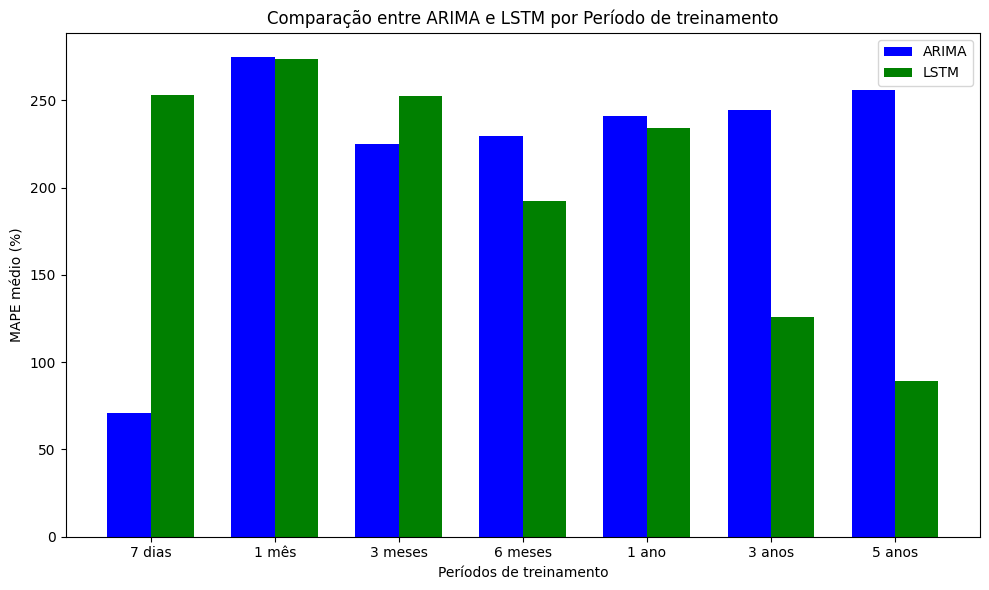

In [75]:
def mostrar_grafico_mapes(dict_mape_means):
    # Extrair os períodos, os valores do ARIMA e do LSTM
    periodos = list(dict_mape_means.keys())
    arima_values = [dict_mape_means[periodo]['arima'] for periodo in periodos]
    lstm_values = [dict_mape_means[periodo]['lstm'] for periodo in periodos]
    
    # Configurações do gráfico
    bar_width = 0.35
    index = np.arange(len(periodos))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Criar as barras
    ax.bar(index, arima_values, bar_width, label='ARIMA', color='b')
    ax.bar(index + bar_width, lstm_values, bar_width, label='LSTM', color='g')
    
    # Título e labels
    ax.set_xlabel('Períodos de treinamento')
    ax.set_ylabel('MAPE médio (%)')
    ax.set_title('Comparação entre ARIMA e LSTM por Período de treinamento')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(periodos)
    ax.legend()
    
    # Exibir o gráfico
    plt.tight_layout()
    plt.show()
    
mostrar_grafico_mapes(dict_mape_means)